In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm import trange

import matplotlib.pyplot as plt

In [2]:
MNIST_ROOT = "/checkpoint/wesbz/Datasets"
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42
batch_size = 128

In [3]:
torch.manual_seed(seed)

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

mnist = MNIST(MNIST_ROOT, train=True, download=True, transform=transform)
transform_loader = DataLoader(mnist, batch_size=60_000, shuffle=True)
tfmd_data = next(iter(transform_loader))
mnist_dataset = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False)

mnist_test = MNIST(MNIST_ROOT, train=False, download=True, transform=transform)
transform_loader = DataLoader(mnist_test, batch_size=10_000, shuffle=False)
tfmd_data = next(iter(transform_loader))
test_data = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
n_h = 10
torch.manual_seed(seed)
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=10)
)

model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=10, bias=True)
  (10): ReLU()
  (11): Linear(in_features=10, out_features=10, bias=True)
)

In [5]:
lr = 1e-1
epochs = 10
# Training
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (epoch+1))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)

hist_train_acc = []
hist_train_loss = []

In [6]:
with trange(epochs) as t:
    for _ in t:

        model.train()

        train_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        train_loss /= len(train_loader)

        # print(f"Train accuarcy: {100. * correct / total:.3f}%")
        train_acc = 100. * correct / total
        hist_train_acc.append(100. * correct / total)
        hist_train_loss.append(train_loss)

        # scheduler.step()

        t.set_postfix(train_acc=train_acc)

test_loss = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        test_loss += loss.item()
        _, predicted = y_pred.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

test_loss /= len(test_loader)

print(f"Test accuracy: {100. * correct / total}%")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.07s/it, train_acc=99.4]

Test accuracy: 97.95%


In [7]:
model.eval()
first_weights = model[-3].weight.detach().clone()

In [8]:
first_weights
print(torch.linalg.svdvals(first_weights))
print(torch.linalg.eigvals(first_weights))

tensor([1.5802, 1.5384, 1.3941, 1.2768, 1.2389, 1.2019, 0.7125, 0.3113, 0.2441,
        0.0885], device='cuda:0')
tensor([-0.8689+0.4442j, -0.8689-0.4442j,  0.2023+0.8579j,  0.2023-0.8579j,
         0.8962+0.2945j,  0.8962-0.2945j,  0.2415+0.5502j,  0.2415-0.5502j,
         0.2690+0.0000j,  0.4826+0.0000j], device='cuda:0')


In [12]:
replay_test_acc = [correct/total]
replay_test_loss = [test_loss]
replay_mapping = [torch.eye(model[-3].out_features).to(device)]
replay_weights = [model[-3].weight.detach().clone()]
replay_biases = [model[-3].bias.detach().clone()]
replay_sv = torch.linalg.svdvals(replay_weights[-1]).tolist()
sv = (torch.linalg.svdvals(replay_weights[-1]) / sum(torch.linalg.svdvals(replay_weights[-1]))).tolist()
replay_sv_norm = sv

In [13]:
model[-3].weight.detach().clone()

tensor([[ 0.3743, -0.2461, -0.1864,  0.1758, -0.4837,  0.4337, -0.0908, -0.1938,
          0.0775,  0.9101],
        [ 0.3518, -0.0815, -0.3007,  0.3127, -0.2790,  0.4332, -0.1184, -0.1155,
          0.4336, -0.2475],
        [ 1.0712, -0.0640,  0.1160,  0.2668,  0.5798, -0.4237,  0.0072,  0.3260,
         -0.1637, -0.2280],
        [-0.1538, -0.0868, -0.3222, -0.3777,  0.7767,  0.9326, -0.0938, -0.2092,
         -0.0516, -0.0420],
        [-0.1577,  0.0411, -0.0958, -0.0401, -0.0412, -0.0820,  0.1432, -0.0148,
         -0.0681, -0.0842],
        [-0.1036,  0.2730,  0.4779,  0.6372, -0.2269,  0.4858, -0.1090, -0.0795,
         -0.4438, -0.5793],
        [-0.0483, -0.1125,  0.0021, -0.0550, -0.0407,  0.1737,  0.1795, -0.0899,
          0.0900, -0.1341],
        [-0.2219, -0.0406, -0.2418,  0.5894,  0.2060, -0.0884,  0.1106,  0.1668,
          0.0263, -0.3220],
        [-0.1068,  0.5559,  0.9492, -0.1595,  0.1799,  0.2320, -0.1934,  0.0832,
          0.5188,  0.1459],
        [-0.2701, -

In [14]:
model[-3].bias.detach().clone()

tensor([ 0.0602, -0.1610,  0.2251,  0.2394, -0.1237, -0.0541, -0.0766, -0.0710,
         0.0754, -0.0285], device='cuda:0')

In [15]:
model[-3].reset_parameters()

In [16]:
model[-3].weight.detach().clone()

tensor([[ 0.0714, -0.3099, -0.0642, -0.2907, -0.2174, -0.0111,  0.1494, -0.0595,
          0.0120, -0.1349],
        [-0.1634,  0.2674,  0.2087, -0.2946, -0.0709, -0.2641,  0.1734, -0.1396,
          0.0088, -0.1854],
        [-0.3116,  0.2372,  0.2961, -0.2403, -0.1915, -0.0315, -0.2839, -0.0068,
          0.2739, -0.0754],
        [-0.2841, -0.1478,  0.0945, -0.1471, -0.2066,  0.2255, -0.1416, -0.1839,
         -0.2713,  0.1708],
        [ 0.0696, -0.0984,  0.3069, -0.0195,  0.2658,  0.1345, -0.2497,  0.1985,
         -0.2472,  0.0695],
        [-0.2055,  0.2154,  0.2343,  0.1446, -0.1555, -0.2108,  0.1436, -0.0641,
         -0.1457,  0.1916],
        [-0.0563, -0.2230, -0.3018, -0.1688, -0.1709, -0.0643, -0.0121, -0.1188,
          0.0772, -0.0910],
        [ 0.0956,  0.2723, -0.1457, -0.2871,  0.3115, -0.1399,  0.0068,  0.0598,
          0.0737, -0.1081],
        [ 0.1920, -0.0025,  0.1251,  0.0915,  0.2567, -0.1081, -0.1991, -0.0919,
          0.1579, -0.1374],
        [ 0.1827,  

In [17]:
model[-3].bias.detach().clone()

tensor([ 0.3085, -0.2347,  0.0393,  0.0140,  0.1546,  0.0604,  0.2939,  0.2517,
         0.1726,  0.1063], device='cuda:0')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=99.8]


Test accuracy: 98.14%


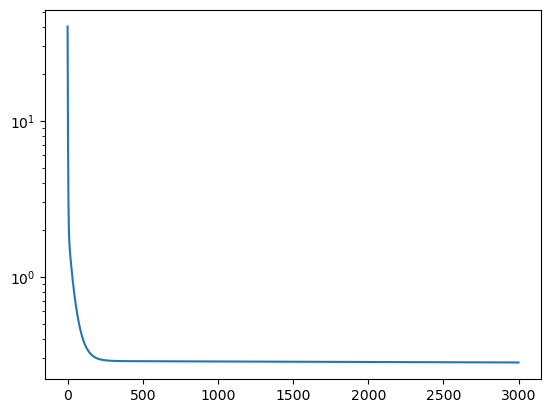

 10%|█████████████████▊                                                                                                                                                                | 1/10 [00:11<01:40, 11.15s/it]

tensor([1.4927, 1.4496, 1.2481, 1.1995, 1.1336, 1.0302, 0.3775, 0.2747, 0.2320,
        0.0043], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.5681+0.9266j,  0.5681-0.9266j,  0.8682+0.0000j,  0.4814+0.4012j,
         0.4814-0.4012j, -0.7252+0.0000j,  0.2700+0.0000j, -0.4731+0.0000j,
         0.0614+0.0000j, -0.1711+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s, train_acc=99.1]


Test accuracy: 98.2%


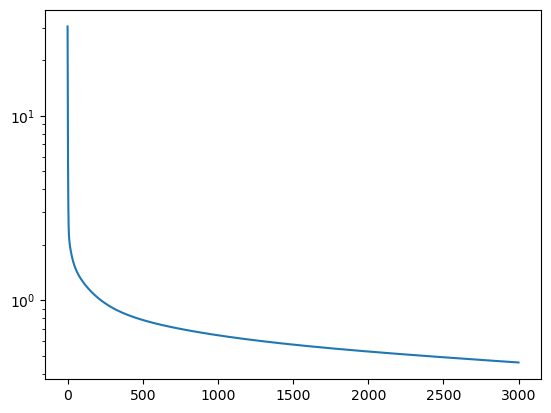

 20%|███████████████████████████████████▌                                                                                                                                              | 2/10 [00:22<01:28, 11.12s/it]

tensor([1.4809, 1.4549, 1.3280, 1.2402, 1.2090, 0.9904, 0.3580, 0.1418, 0.0654,
        0.0173], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-1.1887+0.0000j,  1.2224+0.0000j, -0.3088+0.6402j, -0.3088-0.6402j,
         0.6455+0.0000j, -0.3906+0.0000j, -0.0255+0.2153j, -0.0255-0.2153j,
         0.1504+0.0732j,  0.1504-0.0732j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s, train_acc=99.9]


Test accuracy: 98.61%


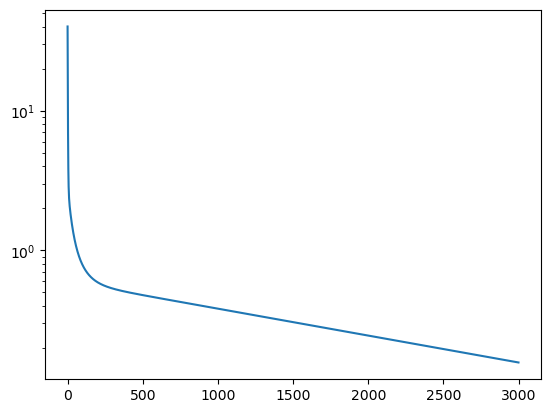

 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 3/10 [00:33<01:17, 11.04s/it]

tensor([1.4945, 1.4488, 1.2749, 1.2142, 1.0932, 0.9316, 0.3711, 0.2570, 0.1815,
        0.0333], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-1.0162+0.0000j,  0.9793+0.0000j,  0.3543+0.7558j,  0.3543-0.7558j,
         0.5958+0.4920j,  0.5958-0.4920j, -0.4475+0.0000j, -0.0130+0.3079j,
        -0.0130-0.3079j, -0.1118+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=99.3]


Test accuracy: 98.33%


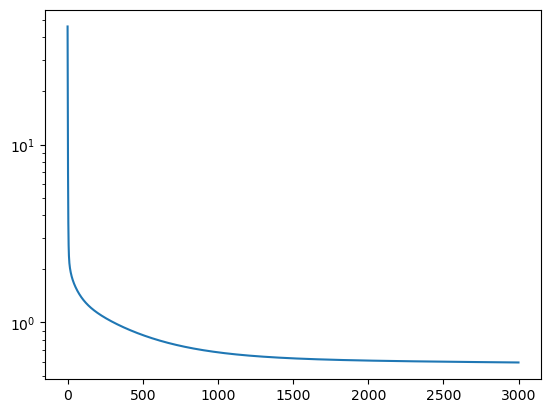

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 4/10 [00:44<01:06, 11.01s/it]

tensor([1.4793, 1.4199, 1.3035, 1.2404, 1.0931, 0.9821, 0.5053, 0.2195, 0.0800,
        0.0065], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.4591+0.7497j, -0.4591-0.7497j, -0.6828+0.0000j,  0.8913+0.2590j,
         0.8913-0.2590j,  0.1121+0.6475j,  0.1121-0.6475j, -0.0160+0.0000j,
         0.3251+0.0000j,  0.2077+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=99.7]


Test accuracy: 98.22%


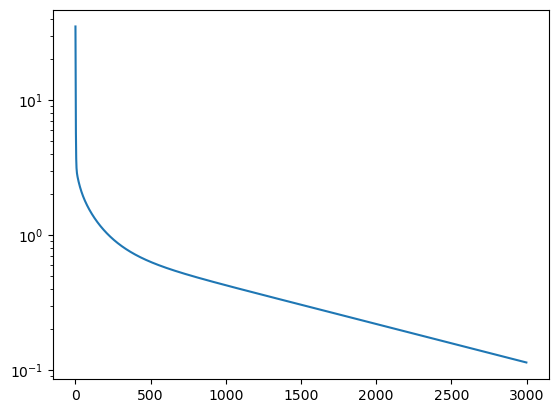

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 5/10 [00:55<00:55, 11.02s/it]

tensor([1.4956, 1.3646, 1.3096, 1.2413, 1.1020, 0.9935, 0.3668, 0.2148, 0.1286,
        0.0405], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 1.0125+0.0000j,  0.6920+0.6554j,  0.6920-0.6554j,  0.6426+0.0000j,
        -0.3034+0.6959j, -0.3034-0.6959j, -0.7793+0.0000j,  0.0804+0.0000j,
        -0.3710+0.0000j, -0.1883+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=100]


Test accuracy: 98.43%


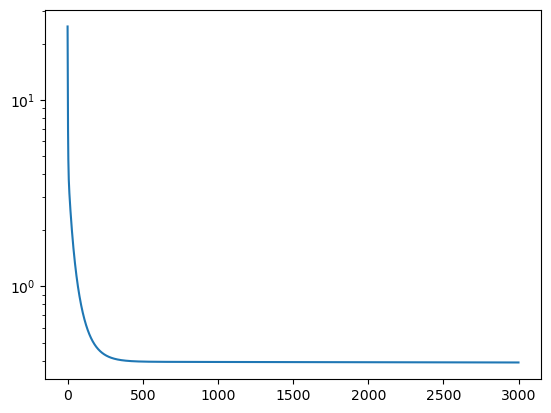

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 6/10 [01:06<00:44, 11.03s/it]

tensor([1.5502, 1.3956, 1.2576, 1.1479, 1.1048, 1.0093, 0.3793, 0.2561, 0.1804,
        0.0028], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.9749+0.3652j, -0.9749-0.3652j,  0.8926+0.0000j,  0.7023+0.1670j,
         0.7023-0.1670j, -0.0829+0.5366j, -0.0829-0.5366j, -0.4076+0.2756j,
        -0.4076-0.2756j,  0.0047+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=100]


Test accuracy: 98.53%


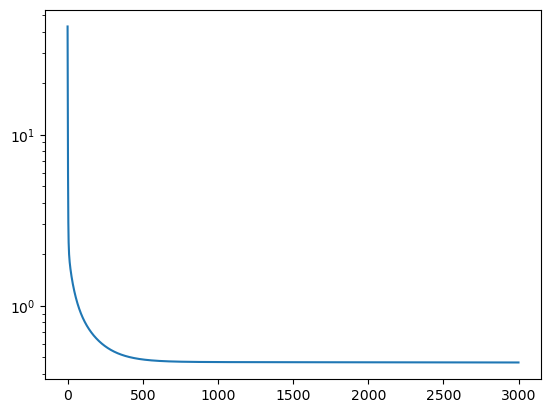

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 7/10 [01:17<00:33, 11.04s/it]

tensor([1.5032, 1.4221, 1.2982, 1.2370, 1.1051, 0.9041, 0.5091, 0.2761, 0.1377,
        0.0024], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 1.0499+0.2297j,  1.0499-0.2297j, -1.1095+0.0000j, -0.6049+0.6828j,
        -0.6049-0.6828j, -0.0162+0.0000j, -0.1271+0.2365j, -0.1271-0.2365j,
        -0.3403+0.1171j, -0.3403-0.1171j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s, train_acc=100]


Test accuracy: 98.33%


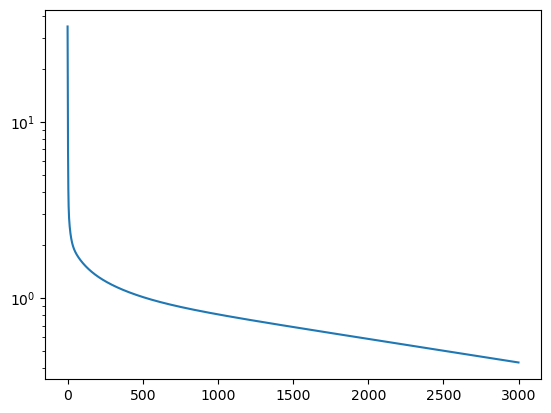

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 8/10 [01:28<00:22, 11.08s/it]

tensor([1.4984, 1.4128, 1.3103, 1.2313, 1.0839, 0.9507, 0.4701, 0.1980, 0.1014,
        0.0277], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.2315+0.5769j,  0.2315-0.5769j,  0.5095+0.2570j,  0.5095-0.2570j,
        -0.7833+0.2884j, -0.7833-0.2884j, -0.1364+0.3231j, -0.1364-0.3231j,
         0.1184+0.0000j, -0.7219+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s, train_acc=97.4]


Test accuracy: 96.85%


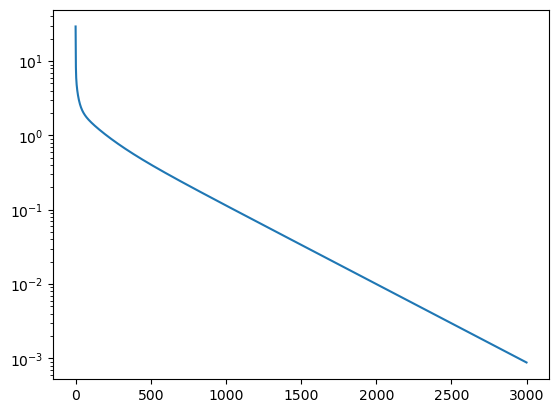

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9/10 [01:39<00:11, 11.15s/it]

tensor([1.7644, 1.5790, 1.3208, 1.2301, 0.9198, 0.7645, 0.4620, 0.3291, 0.1389,
        0.0779], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-1.2607+0.0000j,  0.7772+0.4881j,  0.7772-0.4881j, -0.6204+0.0000j,
        -0.4220+0.5031j, -0.4220-0.5031j,  0.2013+0.4487j,  0.2013-0.4487j,
         0.5056+0.0000j, -0.1508+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s, train_acc=99.9]


Test accuracy: 98.48%


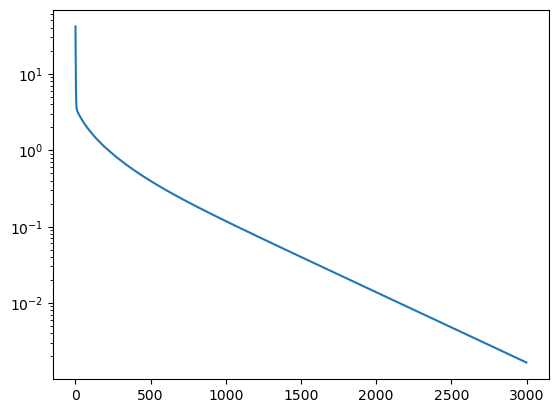

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.10s/it]

tensor([1.4564, 1.3697, 1.3217, 1.2219, 1.1495, 1.0221, 0.3608, 0.2149, 0.1264,
        0.0728], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-1.0760+0.0000j,  1.1973+0.0000j, -0.5589+0.5226j, -0.5589-0.5226j,
         0.4743+0.3004j,  0.4743-0.3004j, -0.1347+0.4595j, -0.1347-0.4595j,
         0.3227+0.0000j,  0.1536+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


In [18]:
torch.seed()
for replay in trange(10):
    model[-3].reset_parameters()
    with trange(epochs) as t:
        for _ in t:

            model[-3].train()

            train_loss = 0.0
            correct = 0
            total = 0

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()

                y_pred = model(X)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = y_pred.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

            train_loss /= len(train_loader)

            # print(f"Train accuarcy: {100. * correct / total:.3f}%")
            train_acc = 100. * correct / total
            hist_train_acc.append(100. * correct / total)
            hist_train_loss.append(train_loss)

            # scheduler.step()

            t.set_postfix(train_acc=train_acc)

    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

    test_loss /= len(test_loader)

    print(f"Test accuracy: {100. * correct / total}%")

    replay_test_acc.append(correct/total)
    replay_test_loss.append(test_loss)
    replay_weights.append(model[-3].weight.detach().clone())
    replay_biases.append(model[-3].bias.detach().clone())

    # Get the mapping
    A = torch.rand(model[-3].out_features, model[-3].out_features).to(device)
    A.requires_grad = True
    map_optimizer = optim.SGD([A], lr=1e-1)
    hist_map_loss = []
    for _ in range(3_000):
        map_optimizer.zero_grad()
        loss = torch.norm(A @ model[-3].weight - first_weights)**2
        loss.backward()
        hist_map_loss.append(loss.item())
        map_optimizer.step()
    plt.figure()
    plt.plot(hist_map_loss)
    plt.yscale("log")
    plt.show(block=False)
    print(torch.linalg.svdvals(model[-3].weight))
    sv = torch.linalg.svdvals(model[-3].weight)
    print(torch.linalg.eigvals(model[-3].weight))
    replay_sv.extend((sv).tolist())
    replay_sv_norm.extend((sv/sum(sv)).tolist())
    replay_mapping.append(A)


In [19]:
replay_mapping                     

[tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0'),
 tensor([[ 8.4942e-01,  3.6239e-04, -2.2403e-01, -1.9830e-01, -6.3598e-02,
           2.6156e-01,  6.2913e-01, -4.9738e-01, -2.0181e-01,  4.2250e-03],
         [ 9.0466e-02,  1.8045e+00,  3.6804e-02, -1.6056e-01,  9.1880e-01,
          -3.3791e-02,  1.4859e-01,  1.2663e+00, -1.2280e-01,  5.6727e-01],
         [-1.2469e-01,  8.8113e-01,  1.0431e+00,  1.2028e-01,  2.2195e-01,
          -1.4158e-01,  3.9680e-01,  4.7496e-01, -3.3167e-01,  3.4158e-01],
         [ 1.6898e

In [20]:
U, S, V = torch.linalg.svd(model[-3].weight)

In [21]:
S

tensor([1.4564, 1.3697, 1.3217, 1.2219, 1.1495, 1.0221, 0.3608, 0.2149, 0.1264,
        0.0728], device='cuda:0', grad_fn=<LinalgSvdBackward0>)

In [22]:
replay_sv

[1.5802265405654907,
 1.538368821144104,
 1.3941316604614258,
 1.276806354522705,
 1.2389353513717651,
 1.201912522315979,
 0.7125484943389893,
 0.31127873063087463,
 0.24409164488315582,
 0.08848235011100769,
 1.4926724433898926,
 1.449571132659912,
 1.2480543851852417,
 1.1994738578796387,
 1.1335726976394653,
 1.0302010774612427,
 0.3774869441986084,
 0.27472323179244995,
 0.23203949630260468,
 0.004309238865971565,
 1.4808930158615112,
 1.4549189805984497,
 1.327976942062378,
 1.2401671409606934,
 1.209030032157898,
 0.9903902411460876,
 0.35796549916267395,
 0.14175227284431458,
 0.06541075557470322,
 0.017259830608963966,
 1.4944959878921509,
 1.4487961530685425,
 1.2748887538909912,
 1.2141826152801514,
 1.0931893587112427,
 0.931634783744812,
 0.3710554540157318,
 0.25702157616615295,
 0.18149559199810028,
 0.033302776515483856,
 1.479283332824707,
 1.4198520183563232,
 1.3034926652908325,
 1.2403644323349,
 1.0931437015533447,
 0.9821498394012451,
 0.505263090133667,
 0.219459

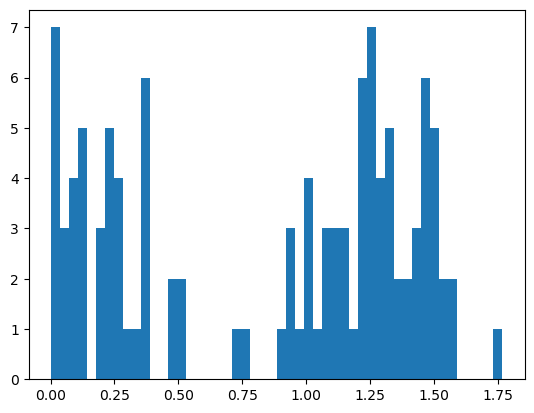

In [23]:
plt.figure()
plt.hist(replay_sv, bins=50)
plt.show()

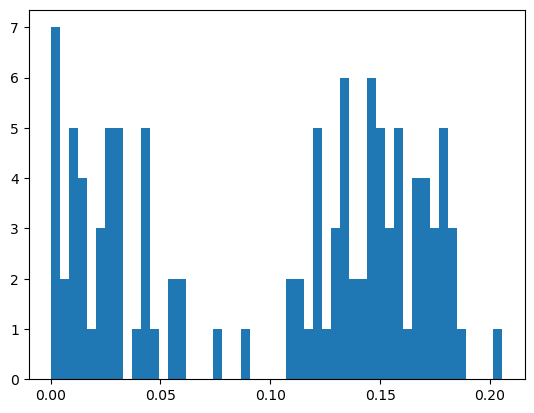

In [24]:
plt.figure()
plt.hist(replay_sv_norm, bins=50)
plt.show()